## 2. PCA for Eigenfaces

In [241]:
import cv2
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
from sklearn.neighbors import NearestNeighbors

plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)

<Figure size 432x288 with 0 Axes>

In [242]:
def p2_preprocess(dirpath='p2_data', n_persons=40, n_images=10, n_train=6, n_test=4, shuffle=False):
    # read images
    person_imgs, person_clss = [], []
    for i in range(n_persons):
        imgs, clss = [], []
        for j in range(n_images):
            imgs += [cv2.imread(osp.join(dirpath, "{:d}_{:d}.png".format(i + 1, j + 1)), 0)]
            clss += [i]
        person_imgs += [imgs]
        person_clss += [clss]
    person_imgs = np.array(person_imgs)
    person_clss = np.array(person_clss)
    
    # split training / testing
    indices = np.arange(n_train + n_test)
    if shuffle:
        np.random.shuffle(indices)
    train_indices, test_indices = indices[:n_train], indices[-n_test:]
    person_imgs_train = person_imgs[:, train_indices]
    person_clss_train = person_clss[:, train_indices]
    person_imgs_test = person_imgs[:, test_indices]
    person_clss_test = person_clss[:, test_indices]
    
    return person_imgs_train, person_clss_train, person_imgs_test, person_clss_test

In [243]:
def err_cnt(y1, y2):
    return np.sum(np.sign(np.abs(y1 - y2)))


def pca(XT_raw):
    XT_mean = np.mean(XT_raw, axis=0)
    XT = XT_raw - XT_mean
    U, Sigma, VT = np.linalg.svd(XT, full_matrices=False)
    #XT_mean, VT = cv2.PCACompute(XT, mean=XT_mean.reshape(1, -1), maxComponents=n_persons * n_images)
    #print('XT = U * Sigma * VT:', XT.shape, U.shape, Sigma.shape, VT.shape)
    return XT, XT_mean, VT


def knn(k, points, Y, test_points):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(test_points)
    neighbors_Y, vote_Y= Y[indices], []
    for neighbors in neighbors_Y:
        vote_Y += [np.argmax(np.bincount(neighbors))]
    return np.array(vote_Y)

In [244]:
def p2(person_imgs_train, person_clss_train, person_imgs_test, person_clss_test, test=False):
    n_persons, n_images, h, w = person_imgs_train.shape
    XT_raw = person_imgs_train.reshape((n_persons * n_images, -1))
    XT, XT_mean, VT = pca(XT_raw)
    Y = person_clss_train.flatten()
    
    display(Markdown('### 2.1.'))
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(10, 2))
    ax[0].imshow(XT_mean.reshape((h, w)))
    ax[0].set_title("Mean Face")
    
    for i in range(4):
        ax[i + 1].imshow(VT[i].reshape((h, w)))
        ax[i + 1].set_title("Eigenface {:d}".format(i + 1))
    
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
    
    # test 100 eigenfaces
    if test:
        rows, cols = 10, 10
        fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
        
        for i in range(100):
            r, c = int(i / 10), int(i % 10)
            ax[r, c].imshow(VT[i].reshape((h, w)))
            ax[r, c].set_title("{:d}".format(i + 1))
            
        plt.setp(ax, xticks=[], yticks=[]); plt.show()

    display(Markdown('### 2.2. 2.3.'))
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(10, 2))
    V = VT.T # eigenvectors (eigenfaces)
    original_img = XT[0]
    n_eigenfaces = [3, 45, 140, 229, len(VT)]
    
    for i, n in enumerate(n_eigenfaces):
        projection_T = np.dot(original_img, V[:, :n])
        reconstruction_T = np.dot(projection_T, VT[:n])
        mse = np.mean((original_img - reconstruction_T) ** 2)
        ax[i].imshow(reconstruction_T.reshape((h, w)))
        ax[i].set_title("n={:d}".format(n))
        ax[i].set_xlabel('mse={:.2f}'.format(mse))
        
    plt.setp(ax, xticks=[], yticks=[]); plt.show()
        
    display(Markdown('### 2.4.'))
    m_fold_cross_validation = 3
    fold_size = int(n_images / m_fold_cross_validation)
    indices = np.arange(n_images)
    n_eigenfaces = [3, 45, 140]
    k_nearest_neighbors = [1, 3, 5]
    errors = np.zeros((len(n_eigenfaces), len(k_nearest_neighbors)))
    
    for m in range(m_fold_cross_validation):
        # split train / validation to each person, not to all images (XT)
        train_indices, val_indices = indices[fold_size:], indices[:fold_size]
        XT_raw_train = person_imgs_train[:, train_indices].reshape((n_persons * len(train_indices), -1))
        XT_raw_val   = person_imgs_train[:, val_indices].reshape((n_persons * len(val_indices), -1))
        Y_train = person_clss_train[:, train_indices].flatten()
        Y_val   = person_clss_train[:, val_indices].flatten()
        # compute eigenfaces by training data
        XT_train, XT_train_mean, VT_train = pca(XT_raw_train)
        
        for i, n in enumerate(n_eigenfaces):
            # project training and validation data onto eigen space
            V_train = VT_train[:n].T
            PT_train = np.dot(XT_train, V_train)
            PT_val = np.dot(XT_raw_val - XT_train_mean, V_train)
            
            for j, k in enumerate(k_nearest_neighbors):
                # find k-nearest-neighbors for each validation data
                Y_val_pred = knn(k, PT_train, Y_train, PT_val)
                err_val = err_cnt(Y_val_pred, Y_val)
                #print('fold={:d}, #eigenfaces={:d}, #neighbors={:d}, err={:d}'.format(m, n, k, err_val))
                errors[i, j] += err_val
                
        indices = np.roll(indices, -fold_size)
    
    errors /= m_fold_cross_validation
    display(pd.DataFrame(errors, index=['n=%d' % n for n in n_eigenfaces], columns=['k=%d' % k for k in k_nearest_neighbors]))
    best_n, best_k = np.where(errors == np.min(errors))
    best_n, best_k = n_eigenfaces[best_n[0]], k_nearest_neighbors[best_k[0]]
    print('best n={:d}, best k={:d}'.format(best_n, best_k))
    
    display(Markdown('### 2.5.'))
    n_persons_test, n_images_test, _, _ = person_imgs_test.shape
    XT_raw_test = person_imgs_test.reshape((n_persons_test * n_images_test, -1)) # reshape test data
    Y_test = person_clss_test.flatten() # gt of test data
    # compute eigenfaces from training data
    XT_train, XT_train_mean, VT_train = pca(XT_raw)
    # project to eigen space
    PT = np.dot(XT, VT_train[:best_n].T)
    PT_test = np.dot(XT_raw_test - XT_train_mean, VT_train[:best_n].T) 
    Y_test_pred = knn(best_k, PT, Y, PT_test)
    err_test = err_cnt(Y_test_pred, Y_test)
    print('test error={:d}'.format(err_test))

### 2.1.

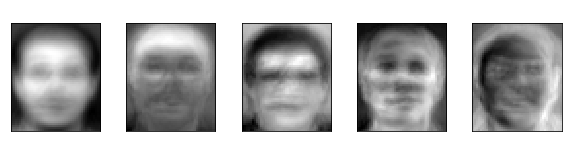

### 2.2. 2.3.

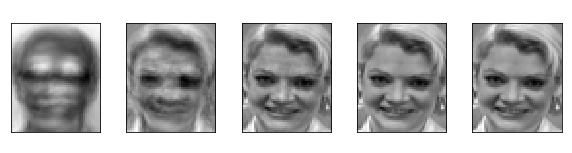

### 2.4.

,k=1,k=3,k=5
n=3,25.666667,32.333333,38.333333
n=45,5.666667,13.333333,17.333333
n=140,5.333333,11.666667,19.333333


best n=140, best k=1


### 2.5.

test error=10


In [245]:
p2(*p2_preprocess(), test=False)